In [1]:
%run "./creds.ipynb"

In [2]:
%run "./api_request.ipynb"

In [3]:
#import libraries
from netCDF4 import Dataset

import numpy as np
import xarray as xr
import pandas as pd

username, pw = get_username_pw() #credentials established in creds.ipynb

#rough boundaries of los angeles
minlong = -118
maxlong = -116
minlat = 33
maxlat = 35


In [4]:
#region map
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#df = aq_data['PM25']

def plot_aq_map(aq_data, time_label = ""):
    fig = plt.figure(figsize=(15, 10))
        
    # create the figure panel and specify size
    fig = plt.figure(figsize=(15, 10))
    
    # create the map using the cartopy PlateCarree projection
    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
    
    # Add lat/lon grid
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    
    # Plot the data
    im = plt.pcolormesh(aq_data.lon, aq_data.lat, aq_data[0,:,:], cmap='YlOrRd', vmin=0, vmax=10) 
    
    # Add coastlines
    ax.coastlines(color='black') 
    
    # Specify the colourbar, including fraction of original axes to use for colorbar, 
    # and fraction of original axes between colorbar and new image axes
    cbar = plt.colorbar(im, fraction=0.025, pad=0.05)
    
    # Define the colourbar label
    cbar.set_label('Average PM 2.5 Levels, %s'%(time_label)) 

    
    #display(fig) #uncomment if not using jupyter inline visualization

Showing monthly average readings on the map

Job ID: 679030e297868e9190f2ee9b
Job status: Accepted
Job status: Succeeded (100% complete)
Job Finished:  Complete (M2TUNXAER_5.12.4)
Retrieved 2 out of 2 expected items

Documentation:
README Document: https://goldsmr4.gesdisc.eosdis.nasa.gov/data/MERRA2_DIURNAL/M2TUNXAER.5.12.4/doc/MERRA2.README.pdf

HTTP_services output:
./data/MERRA2_400.tavgU_2d_aer_Nx.202401.nc4.nc4 is downloaded


<Figure size 1500x1000 with 0 Axes>

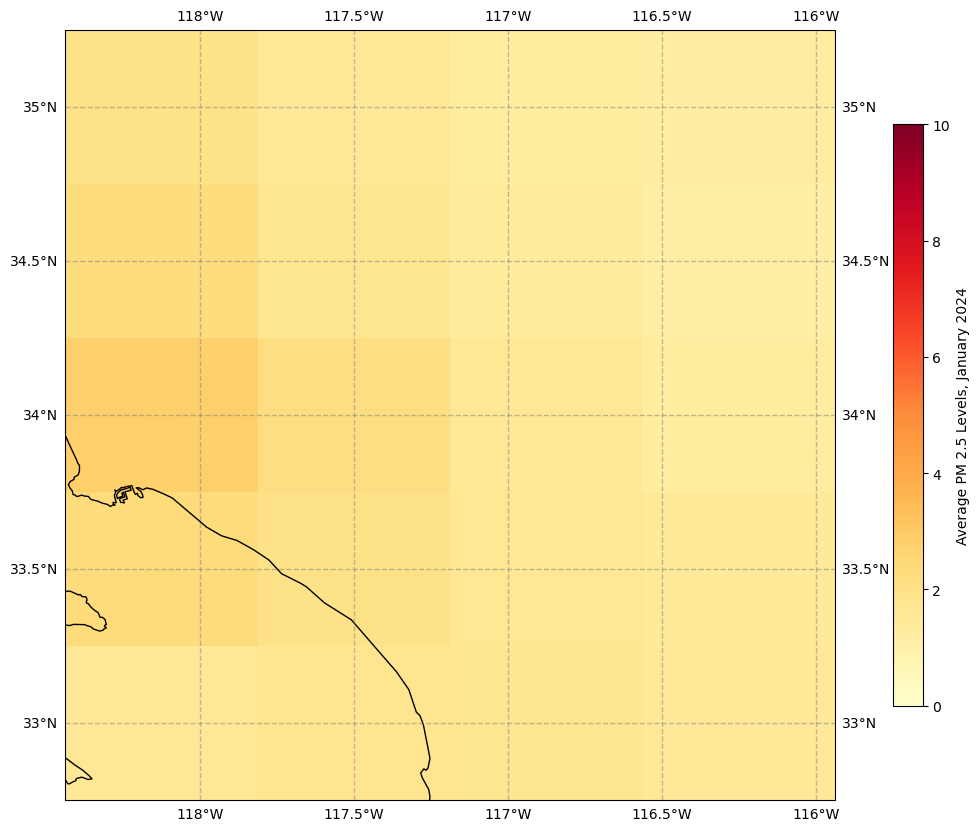

In [5]:
aq_dataset_jan24 = get_pm25_data(username, pw, start_date='2024-01-01', end_date='2024-02-01', minlong=minlong, maxlong=maxlong, minlat=minlat, maxlat=maxlat)
aq_data_jan24 = open_ncfile(aq_dataset_jan24[0])
plot_aq_map(aq_data_jan24['pm25'], time_label='January 2024')

Job ID: 679030f1076b3091d2702a62
Job status: Accepted
Job status: Succeeded (100% complete)
Job Finished:  Complete (M2TUNXAER_5.12.4)
Retrieved 2 out of 2 expected items

Documentation:
README Document: https://goldsmr4.gesdisc.eosdis.nasa.gov/data/MERRA2_DIURNAL/M2TUNXAER.5.12.4/doc/MERRA2.README.pdf

HTTP_services output:
./data/MERRA2_400.tavgU_2d_aer_Nx.202408.nc4.nc4 is downloaded


<Figure size 1500x1000 with 0 Axes>

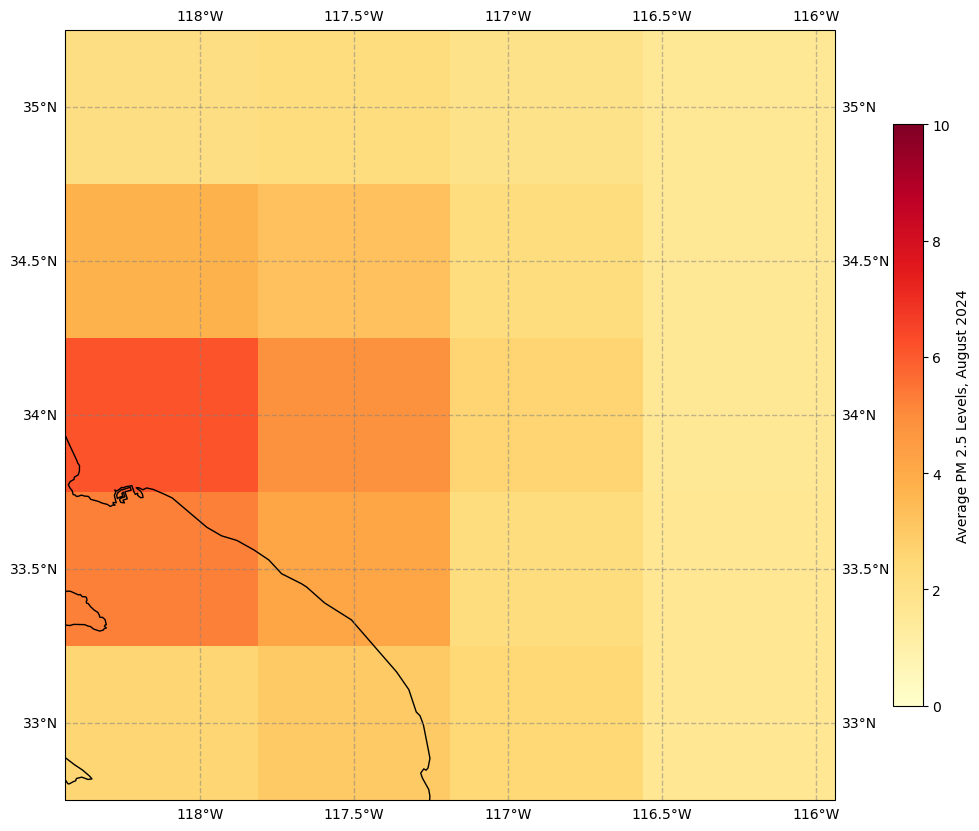

In [6]:
aq_dataset_aug24 = get_pm25_data(username, pw, start_date='2024-08-01', end_date='2024-09-01', minlong=minlong, maxlong=maxlong, minlat=minlat, maxlat=maxlat)
aq_data_aug24 = open_ncfile(aq_dataset_aug24[0])
plot_aq_map(aq_data_aug24['pm25'], time_label='August 2024')

Pulling data for the past 10 years

Run in batches of 1 year to put less strain on the api server and lower the amount of memory needed at one time

In [7]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import time

pull_year = datetime(2014, 1, 1)
end_year = datetime(2025, 1, 1)

aq_monthly_data_arr = []

while pull_year < end_year:
    start_dt = pull_year.strftime("%Y-%m-%d")
    end_dt = (pull_year+relativedelta(years=1)-relativedelta(days=1)).strftime("%Y-%m-%d")
    aq_dataset = get_pm25_data(username, pw, start_date=start_dt, end_date=end_dt, minlong=minlong, maxlong=maxlong, minlat=minlat, maxlat=maxlat)
    aq_dfs = [agg_long_lat(open_ncfile(aq_arr)) for aq_arr in aq_dataset]
    aq_monthly_data = xr.concat(aq_dfs, dim="time")
    aq_monthly_data_arr.append(aq_monthly_data)

    pull_year+=relativedelta(years=1)
    time.sleep(30)#pause for 30 seconds

#concatenate the years of data
aq_monthly_data_full = xr.concat(aq_monthly_data_arr, dim="time")
#save aq_monthly_data
aq_monthly_data_full.to_netcdf("./data/aq_monthly_data.nc")

Job ID: 6790310e70d23092363f2354
Job status: Accepted
Job status: Running (96% complete)
Job status: Succeeded (100% complete)
Job Finished:  Complete (M2TUNXAER_5.12.4)
Retrieved 13 out of 13 expected items

Documentation:
README Document: https://goldsmr4.gesdisc.eosdis.nasa.gov/data/MERRA2_DIURNAL/M2TUNXAER.5.12.4/doc/MERRA2.README.pdf

HTTP_services output:
./data/MERRA2_400.tavgU_2d_aer_Nx.201401.nc4.nc4 is downloaded
./data/MERRA2_400.tavgU_2d_aer_Nx.201402.nc4.nc4 is downloaded
./data/MERRA2_400.tavgU_2d_aer_Nx.201403.nc4.nc4 is downloaded
./data/MERRA2_400.tavgU_2d_aer_Nx.201404.nc4.nc4 is downloaded
./data/MERRA2_400.tavgU_2d_aer_Nx.201405.nc4.nc4 is downloaded
./data/MERRA2_400.tavgU_2d_aer_Nx.201406.nc4.nc4 is downloaded
./data/MERRA2_400.tavgU_2d_aer_Nx.201407.nc4.nc4 is downloaded
./data/MERRA2_400.tavgU_2d_aer_Nx.201408.nc4.nc4 is downloaded
./data/MERRA2_400.tavgU_2d_aer_Nx.201409.nc4.nc4 is downloaded
./data/MERRA2_400.tavgU_2d_aer_Nx.201410.nc4.nc4 is downloaded
./data

Create Boxplots to look at the variance of the data in a given year

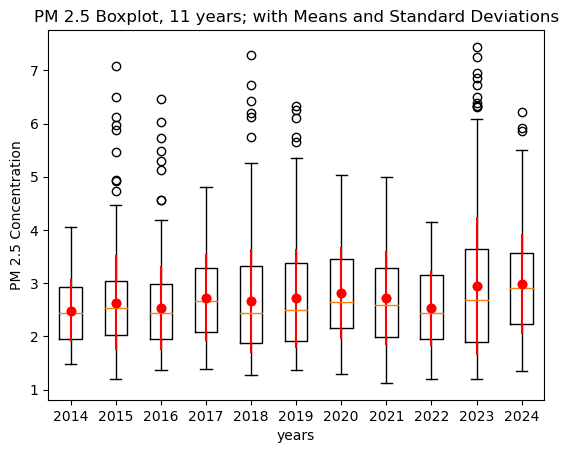

In [11]:
#box plots
year_labels = []; aq_data_by_yearly = []
for key, val in aq_monthly_data_full.groupby('time.year').groups.items():
    year_labels.append(key)
    aq_data_by_yearly.append(aq_monthly_data_full['pm25'].isel(time=val).data)
mean = [np.mean(d) for d in aq_data_by_yearly]
std_devs = [np.std(d) for d in aq_data_by_yearly]
plt.boxplot(aq_data_by_yearly, positions=[x for x in range(1,len(year_labels)+1)], labels=year_labels)
for i in range(len(mean)):
   plt.plot(i + 1, mean[i], 'ro')
# Adds standard deviations as error bars
for i in range(len(std_devs)):
   plt.errorbar(i + 1, mean[i], yerr=std_devs[i], fmt='o', color='red')
plt.title('PM 2.5 Boxplot, %s years; with Means and Standard Deviations'%(str(len(year_labels)))) 
plt.xlabel('years')
plt.ylabel('PM 2.5 Concentration')
plt.show()

In [9]:
print(aq_monthly_data_full.groupby('time.year').mean()['pm25'])

<xarray.DataArray 'pm25' (year: 11)>
array([2.48220794, 2.63084974, 2.53406702, 2.73005507, 2.66337141,
       2.71787387, 2.81496002, 2.72407057, 2.52952908, 2.94282638,
       2.98603915])
Coordinates:
  * year     (year) int64 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024


Plot the time series

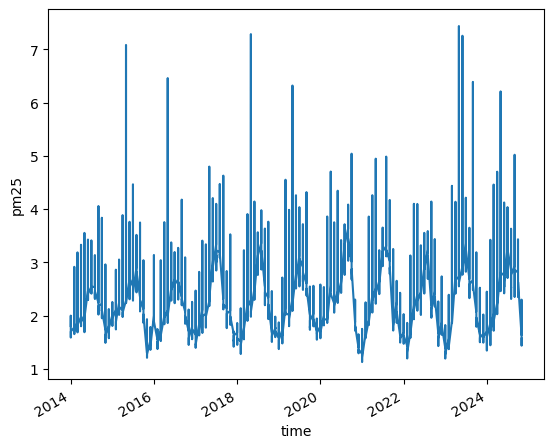

In [10]:
aq_monthly_data_full['pm25'].plot.line()